In [2]:
import os
import numpy as np
import pandas as pd
import xml.etree.ElementTree as XMLTree

import matplotlib.pyplot as plt

from skimage import io
from skimage import color
from skimage.transform import resize

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils import compute_class_weight
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

## Part 1 | Data Processing
---

The data was downloaded and stored under the `data/` folder of the project's directory. Two sub-folders were created, namely `xml/` and `img/` for storing project's respective data types. Last but not least, the TM `.csv` file was stored under the same directory as well.

We will approach the data structuring of the project as follows:
- load the `.csv` metadata file and keep just the TM and date columns into `df_TM` dataframe
- traverse `.xml` files, extract respective image's text and store the filename, TM and corpus data for every file
- transform the above stored information into a new dataframe, `df_corpus`
- load images into `df_img` along with their TM info
- merge all the above dataframes starting from `df_corpus` to `df_img` on file name and then `df_TM` on TM label

We start the `.csv` metadata file:

In [3]:
# Read TM .csv file
df_TM = pd.read_csv('data/TM_Date_Place.csv', low_memory=False)
df_TM = df_TM[['TM_Number', 'Date_notBefore', 'Date_notAfter', 'Date_when']] # keep only needed columns
df_TM.head()

,TM_Number,Date_notBefore,Date_notAfter,Date_when
0,1,NaN,NaN,-154
1,10,NaN,NaN,-129
2,100,NaN,NaN,-125
3,1000,NaN,NaN,-259
4,101,NaN,NaN,-126


We move on to the corpus of the `.xml` files:

In [4]:
# Read .xml files
data_dir = './data/xml/'
all_files = os.listdir(data_dir)
files, TM, corpus = [], [], []
for file in all_files: # traverse directory files
    text = []
    xml_tree = XMLTree.parse(data_dir + file)
    for elem in xml_tree.iter(): # traverser xml object
        if 'CONTENT' in elem.attrib: # string corpus under CONTENT tag
            curr = elem.attrib['CONTENT']
            if curr != '': # discard empty tags
                text.append(curr)
    TM.append(file.split('_')[0]) # TM of object
    files.append(file.split('.xml')[0].split('.jpg')[0]) # file name
    corpus.append(''.join(text)) # corpus of object

df_corpus = pd.DataFrame({
    'file': files,
    'TM': TM,
    'corpus': corpus
})
df_corpus.head()

,file,TM,corpus
0,10545_columbia.apis.p244.f.0.600,10545,ΑΣΚΛΗΠΙΑΔΗΙΒΑΣΙΛΙΚΩΙΓΡΑΜΜΑ̣ΤΙ̣ΠΑΡΑΜΑΡΣΙ̣ΣΟΥΧΟΥ...
1,10546_columbia.apis.p246.f.0.600,10546,[? ?]ΑΣΚΛΗΠΙΑΔΗΙΤΩΙΔΙΟΙΚΗΤΗΙ[? ?]ΧΑΙΡΕΙΝ[-----...
2,10547_columbia.apis.p248.f.0.600,10547,[-----]Τ̣ΗΙΓΕΓΥΜ̣Ν̣ΑΣΙΑΡΧΗΚ̣ΟΤΕΙΚ̣[------][ΠΑΤ...
3,10548_columbia.apis.p253.f.0.600,10548,[-----]ΜΑΙΩΙΒΑΣΙΛΓΡΑΑΡΠΟΛΜΕΡΙΔΟΣ[----]Τ̣ΑΑΡΜΙΥ...
4,10549_columbia.apis.p258.f.0.600,10549,ΑΝΤ[ΙΓΡ](ΑΦΟΝ)Χ̣[ΕΙΡΟΓΡ]Α̣ΦΟΥΚΛΑΥΔΙΟΣΚΑΛΛΙΝΙΚΟ...


To read the images of the project we will utilize the function `read_image`. The function reads an image, converts it to the grayscale color space and resizes it to a `200x200` format:

In [5]:
def read_image(path: str, h: int=200, w: int=200) -> list:

    """
    Read and return a (h, w) array of the image from given directory.

    PARAMETERS
        @ path: string of directory
        @ h: height of desired image resize
        @ w: width of desired image resize
        @ color: color space conversion code

    RETURNS
        (h, w) array of image
    """

    img = io.imread(path)
    img = resize(img, (h, w), anti_aliasing=True)
    img = color.rgb2gray(img[:, :, :3]) # discard alpha (transparency) channel, function expect a 3-dimension RGB image
    return img

We then read the images into a new dataframe:

In [6]:
# Read images
files, TM, images = [], [], []
data_dir = './data/img/'
for img_path in os.listdir(data_dir):
    curr = read_image(f"{data_dir}/{img_path}")
    images.append(curr) # image
    TM.append(img_path.split('_')[0]) # TM of image
    files.append(img_path.split('.xml')[0].split('.jpg')[0]) # name of image file

df_img = pd.DataFrame({
    'file': files,
    'TM': TM,
    'image': images
})
df_img.head()

,file,TM,image
0,10545_columbia.apis.p244.f.0.600,10545,"[[0.5334817612127536, 0.5317219513713985, 0.53..."
1,10546_columbia.apis.p246.f.0.600,10546,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
2,10547_columbia.apis.p248.f.0.600,10547,"[[0.5565292344553376, 0.543096439712372, 0.538..."
3,10548_columbia.apis.p253.f.0.600,10548,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999991..."
4,10549_columbia.apis.p258.f.0.600,10549,"[[1.0, 0.9999704221032993, 0.9982836217819988,..."


As a last step we will combine the above dataframes:

In [7]:
# Merge dataframes
df = df_corpus.merge(df_img, left_on='file', right_on='file', suffixes=('', '_y')) # merge image and corpus on file name
df = df.merge(df_TM, left_on='TM', right_on='TM_Number') # merge images and metadata on TM

Before creating the century column we will handle the missing dates for our images. Since we are using `Date_notBefore` as our final date column, we would need to impute/infer the respective missing values. In order to avoid assumptions, whenever a missing value is encountered in the `Date_notBefore` column, we will replace it with the year value found in `Date_when`. We chose not to use the `Date_notAfter` column, in order to keep the essence of *not before* column intact.

In [8]:
# Handle missing dates, create century column
df['Date_when'] = df['Date_when'].fillna(0) # replace NaN with 0
df['Date_notBefore'] = df['Date_notBefore'].fillna(0)

df['Date_when'] = df['Date_when'].apply(lambda x: int(x.split('-')[0]) if len(str(x)) > 4 else int(x)) # clean dates, keep just the year
df['Date_notBefore'] = df['Date_notBefore'].apply(lambda x: int(x.split('-')[0]) if len(str(x)) > 4 else int(x))

df['date'] = np.where(df['Date_notBefore'] != 0, df['Date_notBefore'], df['Date_when']) # final date column
df = df.drop(df[df['date'] == 0].index) # remove instances where year is not available and can not be imputed
df['century'] = df['date'].apply(lambda x: x//100 + 1 if x >= 0 else -1 * (abs(x)//100) -1) # compute century

df = df[['file', 'TM', 'image', 'corpus', 'century']] # keep just needed columns
df.head()

,file,TM,image,corpus,century
0,10545_columbia.apis.p244.f.0.600,10545,"[[0.5334817612127536, 0.5317219513713985, 0.53...",ΑΣΚΛΗΠΙΑΔΗΙΒΑΣΙΛΙΚΩΙΓΡΑΜΜΑ̣ΤΙ̣ΠΑΡΑΜΑΡΣΙ̣ΣΟΥΧΟΥ...,1
1,10546_columbia.apis.p246.f.0.600,10546,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",[? ?]ΑΣΚΛΗΠΙΑΔΗΙΤΩΙΔΙΟΙΚΗΤΗΙ[? ?]ΧΑΙΡΕΙΝ[-----...,1
2,10547_columbia.apis.p248.f.0.600,10547,"[[0.5565292344553376, 0.543096439712372, 0.538...",[-----]Τ̣ΗΙΓΕΓΥΜ̣Ν̣ΑΣΙΑΡΧΗΚ̣ΟΤΕΙΚ̣[------][ΠΑΤ...,1
3,10548_columbia.apis.p253.f.0.600,10548,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999991...",[-----]ΜΑΙΩΙΒΑΣΙΛΓΡΑΑΡΠΟΛΜΕΡΙΔΟΣ[----]Τ̣ΑΑΡΜΙΥ...,2
4,10549_columbia.apis.p258.f.0.600,10549,"[[1.0, 0.9999704221032993, 0.9982836217819988,...",ΑΝΤ[ΙΓΡ](ΑΦΟΝ)Χ̣[ΕΙΡΟΓΡ]Α̣ΦΟΥΚΛΑΥΔΙΟΣΚΑΛΛΙΝΙΚΟ...,2


We will then visualize the century distribution:

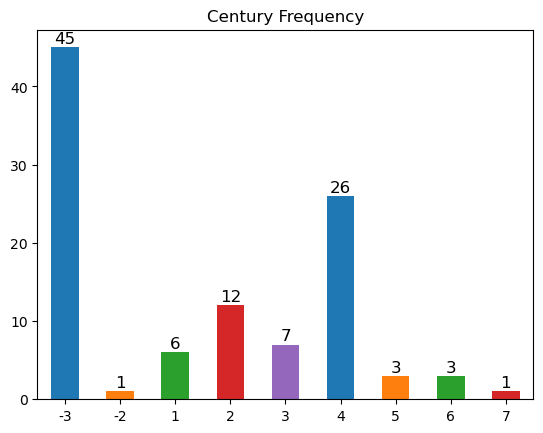

In [9]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'] # global color list

# sort index, necessary for the data label positioning
plot = df['century'].value_counts().sort_index().plot(kind='bar', title='Century Frequency', rot=0, color=colors)

i = 0 # data label counter
# https://bit.ly/3DteCBO | place value annotations at the center of the bars
for rect in plot.patches:
    x_value = rect.get_x() + rect.get_width() / 2
    y_value = rect.get_height() + 0.5
    plt.annotate(list(df['century'].value_counts().sort_index())[i], xy = (x_value, y_value), ha='center', fontsize=12, color='black')
    i += 1

We notice that centuries -2 and 7 have only one image instance, which in a classification task, does not cover the bare minimum requirements for training. Hence, we will remove these instances from our dataset:

In [10]:
# Discard unwanted instances
df = df.drop(df[(df['century'] == -2) | (df['century'] == 7)].index).reset_index(drop=True)
df = df.drop_duplicates('file') # discard duplicate files created from metadata joining

print('Total images after preprocessing: {}'.format(len(df.index)))

Total images after preprocessing: 101


## Part 2 | Century Classification with respect to Images
---

We are going to use the Convolutional Neural Network that we developed during the previous assignment in order to classify the images with respect to their century.

As a first step we will separate our datasets and compute the class weight of the centuries, a dictionary that will be passed to the training step of the algorithm and indicates from which class or classes the model ought to learn more. This step is important considering that our centuries are not balanced among the images:

In [11]:
# Prepare data for CNN input
x_ds1 = np.array(df['image'].tolist()) # select just the 2d images
_, y_ds1 = np.unique(df['century'], return_inverse=True)

# Compute class weight
class_weight_ds1 = compute_class_weight(class_weight='balanced', classes=np.unique(y_ds1), y=y_ds1)
class_weight_ds1 = dict(enumerate(class_weight_ds1)) # https://bit.ly/3EU5NAL | numpy array to dictionary

We are going to split the data in 80% training and 20% testing. From the training data we will use 15% for validation:

In [12]:
# Dataset 1
X_train_ds1, X_test_ds1, y_train_ds1, y_test_ds1 = train_test_split(x_ds1, y_ds1, test_size=0.20, random_state=42) # split test
X_train_ds1, X_val_ds1, y_train_ds1, y_val_ds1 = train_test_split(X_train_ds1, y_train_ds1, test_size=0.15, random_state=42) # split train, validation

# Summary
print('Dataset 1')
print('Train:       X=%s, y=%s' % (X_train_ds1.shape, y_train_ds1.shape))
print('Validation:  X=%s,  y=%s' % (X_val_ds1.shape, y_val_ds1.shape))
print('Test:        X=%s, y=%s' % (X_test_ds1.shape, y_test_ds1.shape))

Dataset 1
Train:       X=(68, 200, 200), y=(68,)
Validation:  X=(12, 200, 200),  y=(12,)
Test:        X=(21, 200, 200), y=(21,)


For the training procedure we will use the `input_fn` function, which basically receives X and y training data and returns PrefetchedDataset objects. The latter are Tensorflow objects that enable faster training, since the model can read the next-to-train batch of data while training the current batch. The batch size, which is set to 8, correspond to the number of images that will flow through the network before a back-propagation operation, and hence a fine-tuning of the weights, takes place. The batch size was set to 8 considering the fact that we do not have much training instances at our disposal.

In [13]:
BATCH_SIZE = 8
AUTOTUNE = tf.data.experimental.AUTOTUNE # size of prefetched data will be optimized at runtime

def input_fn(X: np.ndarray, y: np.ndarray, batch_size: int=BATCH_SIZE):

    """
    Receives X and y training data and transforms them in PrefetchDataset objects.
    The data is shuffled and batched in the specified size.
    tf.data.experimental.AUTOTUNE is used for calculating the size of prefetched data at runtime according to resource heuristics.

    PARAMETERS
        @ X: X training numpy array
        @ y: y training numpy array
        @ BATCH_SIZE: int corresponding to the training batch size

    RETURNS
        PrefetchedDataset object dataset
    """

    # https://bit.ly/3uiStRi | shuffle, repeat, batch
    curr_ds = tf.data.Dataset.from_tensor_slices((X, y)) # initialize dataset
    curr_ds = curr_ds.shuffle(buffer_size=len(X_train_ds1)) # shuffle data, buffer size = maximum size of training data
    curr_ds = curr_ds.repeat() # repeat indefinitely
    curr_ds = curr_ds.batch(batch_size) # batch in specified size
    curr_ds = curr_ds.prefetch(buffer_size=AUTOTUNE) # PrefetchDataset object
    return curr_ds

We initialize the training and testing datastreams:

In [14]:
train_ds1 = input_fn(X_train_ds1, y_train_ds1, BATCH_SIZE) # PrefetchedDataset objects
validation_ds1 = input_fn(X_val_ds1, y_val_ds1, BATCH_SIZE)
test_ds1 = input_fn(X_test_ds1, y_test_ds1, BATCH_SIZE)

As mentioned above we will utilize the LeNet inspired model we developed during the second assignment of the course. Considering the small amount of image instances that our dataset holds, the two hidden layers seem enough, since adding more layers, and as a result more parameters, will enable over-fitting. For the same reason, we made the decision not to include Dropout layers. Last but not least, the loss function the training model is trying to minimize is the Sparse Categorical Cross Entropy, since our labels are not one-hot-encoded. We note that the last fully-connected layer of the network is set to the number of classes of the classification task, i.e. 7.

In [15]:
def init_adam_model(summary: bool, nodes: int) -> models.Sequential:

    """
    Sets up and returns a LeNet inspired CNN architecture.
    Optimizer: Adam
    Loss: Sparse Categorical Cross Entropy

    PARAMETERS
        @ summary: boolean, display model summary
        @ nodes: number of nodes at the last fully-connected layer

    RETURNS
        keras sequential model
    """

    # https://bit.ly/3Ummevd | LeNet architecture
    model = models.Sequential()

    model.add(layers.Conv2D(20, 5, activation='relu', padding='same', input_shape=(200, 200, 1)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(layers.Conv2D(50, 5, activation='relu', padding="same"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(500, activation='relu'))

    model.add(layers.Dense(100, activation='relu'))

    model.add(layers.Dense(nodes, activation='softmax'))

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

    if summary:
        model.summary()

    return model

We will also implement the following functions that help us visualize the learning curves of the training process and evaluates the model on the test set:

In [16]:
def summarize_diagnostics(history: tf.keras.callbacks.History) -> plt.figure :

    """
    Plots training and validation learning curves.
    Two subplots are created, each one of them comparing training/validation loss and accuracy respectively.

    PARAMETERS
        @ history: model history callback

    RETURNS
        a matplot figure consisting of two subplots, one for loss, one for accuracy

    """

    plt.figure(figsize=(16, 8))
    plt.suptitle('Training Curves')
    plt.subplot(1, 2, 1) # plot loss
    plt.title('Cross Entropy Loss')
    plt.plot(history['loss'], color='tab:blue', label='train')
    plt.plot(history['val_loss'], color='tab:orange', label='val')
    plt.legend(loc='upper right')
    plt.subplot(1, 2, 2) # plot accuracy
    plt.title('Classification Accuracy')
    plt.plot(history['accuracy'], color='tab:blue', label='train')
    plt.plot(history['val_accuracy'], color='tab:orange', label='val')
    plt.legend(loc='lower right')
    return plt

def model_evaluation(model: models.Sequential, test_ds, X_test: np.ndarray) -> None:

    """
    Evaluates given model to given test set.
    Prints test and evaluation metrics.

    PARAMETERS
        @ model: keras model that will be evaluated on given testing data
        @ test_ds: PrefetchedDataset object corresponding to testing data X, y
        @ X_test: numpy array corresponding to X testing data, used for calculating evaluations steps

    RETURNS
        None
    """

    print('Test set evaluation metrics')
    loss, accuracy = model.evaluate(test_ds, steps=X_test.shape[0]//BATCH_SIZE) # steps are given since our data is PrefetcedDataset objects!
    print("Cross Entropy Loss: {:.2f}".format(loss))
    print("Accuracy: {:.2f}".format(accuracy))

def model_report(model: models.Sequential, history: tf.keras.callbacks.History, test_ds, X_test: np.ndarray) -> None:

    """
    Wrapper function of summarize_diagnostics and model_evaluation functions.
    Evaluates given model on testing data.
    Plots learning curves for training and validation steps.

    PARAMS
        @ model: keras model that will be evaluated on given testing data
        @ history: model history callback
        @ test_ds: PrefetchedDataset object corresponding to testing data X, y
        @ X_test: numpy array corresponding to X testing data, used for calculating evaluations steps

    RETURNS
        None
    """

    plt = summarize_diagnostics(history)
    plt.show()
    model_evaluation(model, test_ds, X_test)

We will start the training process by initializing the CNN model:

In [17]:
model_ds1 = init_adam_model(summary=True, nodes=7) # 7 centuries

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 20)      520       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 20)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 50)      25050     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 50)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 125000)            0         
                                                                 
 dense (Dense)               (None, 500)               6

The model has 62 million trainable parameters. We move on to training the model for 50 epochs:

In [18]:
model_train_ds1 = model_ds1.fit(
    train_ds1,
    epochs=50,
    steps_per_epoch=X_train_ds1.shape[0]//BATCH_SIZE,
    validation_data=validation_ds1,
    validation_steps=X_val_ds1.shape[0]//BATCH_SIZE,
    class_weight=class_weight_ds1
)

Epoch 1/50
8/8 [==============================] - 3s 347ms/step - loss: 3.8404 - accuracy: 0.1875 - val_loss: 1.8566 - val_accuracy: 0.2500
Epoch 2/50
8/8 [==============================] - 2s 302ms/step - loss: 1.9110 - accuracy: 0.3750 - val_loss: 1.9365 - val_accuracy: 0.3750
Epoch 3/50
8/8 [==============================] - 2s 282ms/step - loss: 1.5681 - accuracy: 0.6250 - val_loss: 1.8630 - val_accuracy: 0.3750
Epoch 4/50
8/8 [==============================] - 2s 300ms/step - loss: 1.7164 - accuracy: 0.7188 - val_loss: 1.6629 - val_accuracy: 0.3750
Epoch 5/50
8/8 [==============================] - 3s 328ms/step - loss: 0.8224 - accuracy: 0.8281 - val_loss: 3.1636 - val_accuracy: 0.3750
Epoch 6/50
8/8 [==============================] - 3s 338ms/step - loss: 0.4025 - accuracy: 0.7812 - val_loss: 1.6829 - val_accuracy: 0.6250
Epoch 7/50
8/8 [==============================] - 2s 305ms/step - loss: 0.3255 - accuracy: 0.9531 - val_loss: 6.1621 - val_accuracy: 0.2500
Epoch 8/50
8/8 [====

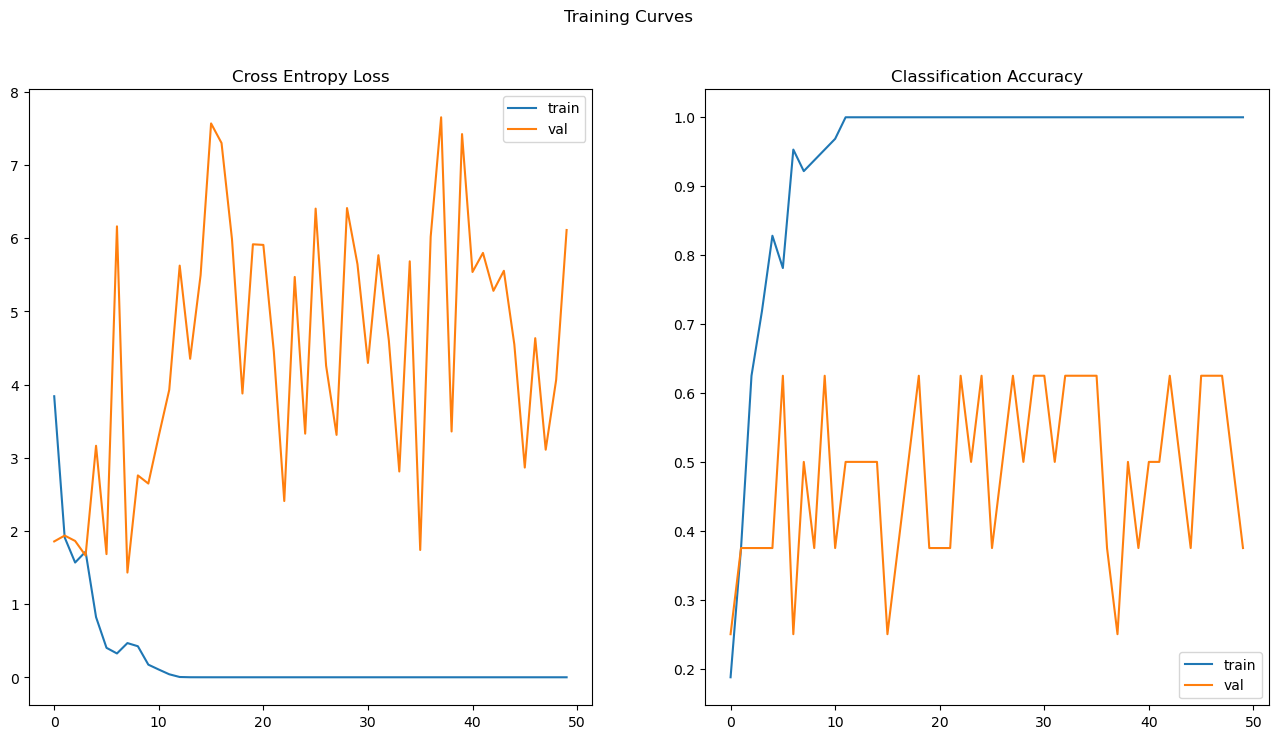

Test set evaluation metrics
2/2 [==============================] - 0s 69ms/step - loss: 3.7819 - accuracy: 0.6875
Cross Entropy Loss: 3.78
Accuracy: 0.69


In [19]:
model_report(model_ds1, model_train_ds1.history, test_ds1, X_test_ds1)

The learning curves of the training process indicate clear over-fitting. We notice how both training lines have reached the minimum and maximum cross entropy loss and classification accuracy, respectively. We note the accuracy achieved on the test set, which barely crosses the 50% mark.

1/1 [==============================] - 0s 276ms/step


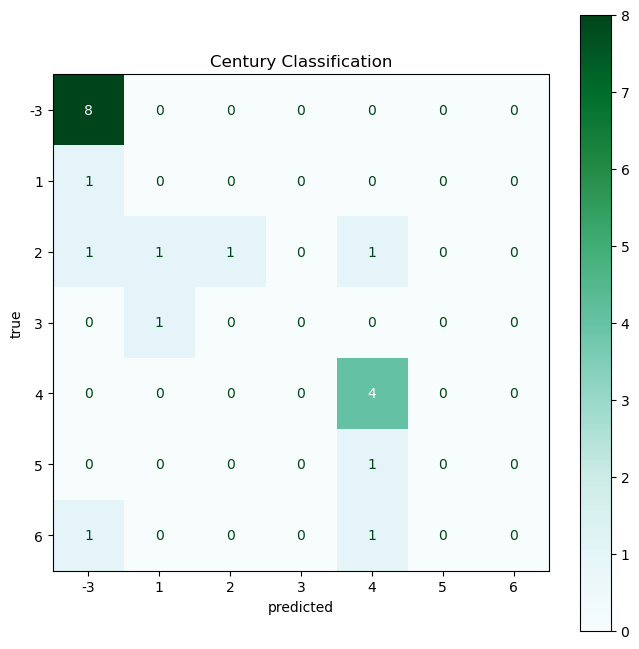

In [20]:
predict_ds1 = model_ds1.predict(X_test_ds1) # prediction probabilities for every class
y_predicted_ds1 = np.argmax(predict_ds1, axis=1) # https://bit.ly/3Vebalb | calculate max probability for every row = predicted class

conf_matrix = confusion_matrix(y_test_ds1, y_predicted_ds1)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels=np.unique(df['century']))
fig, ax = plt.subplots(figsize=(8, 8))
cm_display.plot(ax=ax, cmap='BuGn')
ax.set_title('Century Classification')
ax.set_xlabel('predicted')
ax.set_ylabel('true')
plt.show()

Moving on to the confusion matrix, we notice that the model achieves the highest precision and recall scores for images coming from the 3rd BC, as well as the 4th AD centuries. The inadequate amount of data becomes apparent, especially for classes 1, 3 5 and 6 where only one support instance is present.

## Part 3 | Century Classification with respect to Corpus
---

We will first remove characters that do not correspond to usual alphabets:

In [21]:
df['corpus'] = df['corpus'].apply(lambda x: ''.join(e for e in x if e.isalnum()))
df = df.drop(df[df['corpus'] == '' ].index)

We will split to training and testing:

In [22]:
X = df['corpus']
y = df['century']

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Since our corpus consist of single-string instances we will use n-grams to compute different length words:

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(analyzer = 'char_wb', ngram_range=(2, 20))

X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

We will train a Naive Bayes classifier:

In [24]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()

clf.fit(X_train_cv, Y_train.ravel())

y_pred = clf.predict(X_test_cv)

In [25]:
from sklearn.metrics import f1_score

score = f1_score(Y_test, y_pred, average='micro')
print('F-1 score : {}'.format(np.round(score,4)))

F-1 score : 0.7


In [26]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, y_pred, target_names=['-3', '2', '4', '5'], zero_division=0))

              precision    recall  f1-score   support

          -3       0.83      1.00      0.91         5
           2       0.50      1.00      0.67         2
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         1

    accuracy                           0.70        10
   macro avg       0.33      0.50      0.39        10
weighted avg       0.52      0.70      0.59        10



We get an F1-score of roughly 70%, but only predicting on 4 out 7 classes.